In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import math
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

In [15]:
#read apple stocks from the csv file
df = pd.read_csv('SPY.csv')
#sample['date'] = pd.to_datetime(sample['date'], format = 'Y%-%m-%d %H:%M:%S')
#get row of date and close
sample = df[['date','close']][:550].set_index('date')
#initiate window size to 2
window_size = 2
num_features = 1
###training preprocessing###
#get first 500 numbers of sample row
train = sample[:500]
#convert the samples to numpy array and reshape
train_num = train.to_numpy().reshape(-1,1)
#initate empty training list
train_x = []
#loop over the numpy array of samples minus the window size and append the number inside train_num array to train_x list
for index in range(len(train_num)-window_size):
    train_x.append(train_num[index:index+window_size])

#set the training data for x and y    
#convert train_x to numpy array and reshape to (2,1)
train_x = np.array(train_x).reshape(-1,window_size*num_features)
#print(train_x)
#train_y starts from the index of the difference of shapes of train_num and train_x
train_y = train_num[train_num.shape[0]-train_x.shape[0]:].reshape(-1)

###Validation preprocessing###
#slice 20 numbers in sample list and set to val
val = sample[500:520]
#convert val to numpy array nd reshape
val_num = val.to_numpy().reshape(-1,1)
val_x = []
for index in range(len(val_num)-window_size):
    val_x.append(val_num[index:index+window_size])
    
#set the validation data for x and y
val_x = np.array(val_x).reshape(-1,window_size*num_features)
val_y = val_num[val_num.shape[0]-val_x.shape[0]:].reshape(-1)

###testing preprocessing###
testing = sample[520:540]
testing_num = testing.to_numpy().reshape(-1,1)

testing_x = []
for index in range(len(testing_num)-window_size):
    testing_x.append(testing_num[index:index+window_size])
    
#set the testing data for x and y
testing_x = np.array(testing_x).reshape(-1,window_size*num_features)
testing_y = testing_num[testing_num.shape[0]-testing_x.shape[0]:].reshape(-1)


In [16]:
#fit linear regression with training data
reg = LinearRegression().fit(train_x, train_y)

In [17]:
#use predict function with validation data on LR
y_hat_val = reg.predict(val_x)

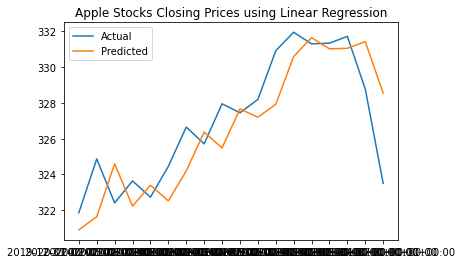

In [18]:
#plot the given stocks data and the predicted data from the validation data
plt.plot(val.tail(val_y.shape[0]).index,val_y,label = 'Actual')
plt.plot(val.tail(val_y.shape[0]).index,y_hat_val,label = 'Predicted')
plt.title('Apple Stocks Closing Prices using Linear Regression')
plt.legend(loc='upper left')

In [19]:
#predict using testing data
y_hat_test = reg.predict(testing_x)
#print(y_hat_test-testing_y)


In [20]:
x = np.array([[1,2,3,4],[5,6,7,8]])
Xy= np.hstack((x,x))
print(Xy) ################################adding features

[[1 2 3 4 1 2 3 4]
 [5 6 7 8 5 6 7 8]]


dict_keys(['C', 'dual', 'epsilon', 'fit_intercept', 'intercept_scaling', 'loss', 'max_iter', 'random_state', 'tol', 'verbose'])
(498,)
(498, 2)


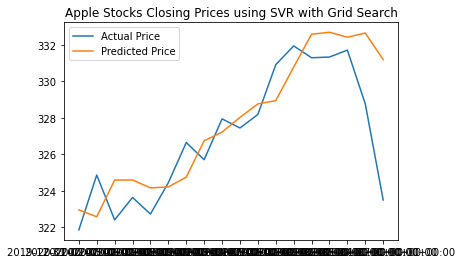

In [21]:
#Grid search for SVR

#initialize the hyperparameters
params = {'C' : [1,5,10],
          'epsilon': [0.001,0.005,0.0075],
         'fit_intercept' : [3,8,5],
         'max_iter' : [0.01,10,0.5],
         'random_state': [0,5,10],}

#find hyperparameters to optimize
print(LinearSVR().get_params().keys())

#create a linear regressor 
SVRModel = LinearSVR(random_state=0, tol=1e-5)
#perform grid search on Linear SVR
grids = GridSearchCV(SVRModel,params,cv=5)
print(train_y.shape)
print(train_x.shape)
#fit the grid with training data
grids = grids.fit(train_x, train_y)
#predict the grid with validation data
y_clf_val = grids.predict(val_x)
#plot the stocks data and the predicted data from the validation data
plt.title('Apple Stocks Closing Prices using SVR with Grid Search')
plt.plot(val.tail(val_y.shape[0]).index,val_y,label = 'Actual Price')
plt.plot(val.tail(val_y.shape[0]).index,y_clf_val,label = 'Predicted Price')
plt.legend(loc='upper left')

In [22]:
def average_gainloss(series, window_size, average):
    a = (window_size-1) / window_size
    ak = a**np.arange(len(series)-1, -1, -1) #arange in descending order
    return np.append(average, np.cumsum(ak * series) / ak / window_size + average * a**np.arange(1, len(series)+1))


def rsi(df, window_size = 14):

    df['change'] = df['close'].diff()
    df['gain'] = df.change.mask(df.change < 0, 0.0)
    df['loss'] = -df.change.mask(df.change > 0, -0.0)
    df.loc[window_size:,'avg_gain'] = average_gainloss( df.gain[window_size+1:].values, window_size, df.loc[:window_size, 'gain'].mean())
    df.loc[window_size:,'avg_loss'] = average_gainloss( df.loss[window_size+1:].values, window_size, df.loc[:window_size, 'loss'].mean())
    df['rs'] = df.avg_gain / df.avg_loss
    df['rsi'] = 100 - (100 / (1 + df.rs))
    
    return df

In [23]:
df = df[:500]
df.shape

(500, 13)

In [29]:
from sklearn.model_selection import train_test_split
#slice first 500 samples
df = df[:500]
newdf = rsi(df)
#remove first 14 rows 
newdf = newdf[14:]
#filter to extract only rsi and close columns
newdf = newdf.filter(['rsi','close'])

#split data into 80% trainging data and test data for validation
X_train, X_test, y_train, y_test = train_test_split(
            newdf['close'], newdf['rsi'], test_size=0.2, random_state=42, shuffle=False)




#convert training data to numpy array and reshape
x_train = np.array(X_train).reshape(-1, 1)
y_train = np.array(y_train).reshape(-1,1)
val_x = np.array(X_test).reshape(-1,1)
val_y = np.array(y_test).reshape(-1,1)


In [30]:
#fit linear regression with training data
df = rsi(df, window_size = 14)
reg = LinearRegression().fit(x_train, y_train)

#use predict function with validation data on LR
y_hat_val = reg.predict(val_x)

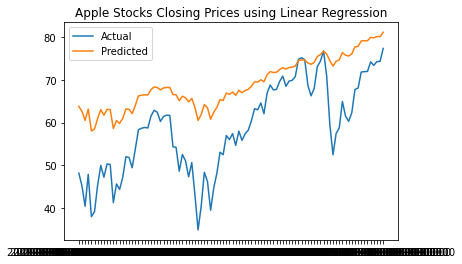

In [31]:
plt.plot(df['date'].tail(val_y.shape[0]).values,val_y,label = 'Actual')
plt.plot(df['date'].tail(val_y.shape[0]).values,y_hat_val,label = 'Predicted')
plt.title('Apple Stocks Closing Prices using Linear Regression')
plt.legend(loc='upper left')